## Clustering

My objective here is to cluster the features, and see the correlation between weather features and sensors.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('./data/Sensor_Weather_Data_Challenge.csv', index_col=0, parse_dates=True)

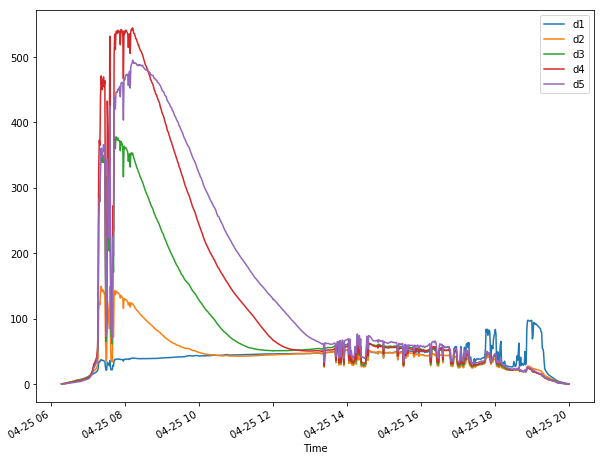

In [110]:
data['2019-04-25'].iloc[:, 0:5].plot(figsize=(10,8))

In [4]:
data.head()

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d13,sky,temperature,humidity,pressure,wind_speed,wind_direction,visibility,storm_dist,storm_direction
Time,,,,,,,,,,,,,,,,,,,,,
2019-03-25 11:40:02,118.69,122.00,174.11,255.76,372.90,445.78,456.13,327.28,261.67,220.01,...,445.95,-30.82,43.71,41.0,1024.73,2.78,260.0,9.96,18.0,350.0
2019-03-25 11:41:02,118.71,122.10,174.09,254.72,371.33,444.66,456.81,328.09,262.33,220.30,...,447.16,-30.30,43.71,41.0,1024.73,2.78,260.0,9.96,18.0,350.0
2019-03-25 11:42:02,118.78,122.22,174.16,253.93,370.31,443.77,457.19,329.17,263.24,220.68,...,449.24,-27.92,43.76,40.0,1024.71,2.88,259.0,9.97,18.0,350.0
2019-03-25 11:43:02,118.82,122.34,174.18,253.00,369.00,442.90,457.58,330.10,263.96,220.95,...,450.82,-28.86,43.81,40.0,1024.69,2.99,258.0,9.97,12.0,263.0
2019-03-25 11:44:02,118.77,122.30,174.16,251.83,367.44,441.34,457.38,330.69,264.55,221.04,...,451.60,-32.86,43.86,40.0,1024.67,3.09,257.0,9.97,12.0,263.0


## Segmentation and Clustering
Refrence: https://www.kaggle.com/zonnalobo/timeseries-segmentation-and-forecasting

Preprocessing: Have used pandas timeseries resample to take the average accross 12 hours. This will give us 2 values per day. I then have grouped them by hour, and resampled for 1 week.The reason I did this is because, I observed that sensor values have a trend across the 12H frames in a day. 
Standard scaled the features before analysis.

Clustering: I used Bayessian Information Criterion (BIC), to find the optimal k to cluster the features. Using k-means algorithm to find cluster id's, and PCA to visulalize clusters


In [142]:
def preprocess_data(rule, cols, group):
    day_sampled=data.resample(rule[0]).mean().loc[:, cols]
    #day_sampled=data.resample('12H').mean()
    day_sampled=day_sampled.fillna(0)
    if group == True:
        day_sampled['hour'] = day_sampled.index.hour
        day_sampled = day_sampled.groupby(['hour'])
        day_sampled = day_sampled.resample(rule[1]).mean().reset_index(drop=True).iloc[:,0:-1]
    
    sc = StandardScaler()
    day_scaled = pd.DataFrame(sc.fit_transform(day_sampled), columns=day_sampled.columns, index=day_sampled.index)
    
    return day_scaled

In [127]:
def plot_BIC(matrix,K):
    from sklearn import mixture
    BIC=[]
    for k in K:
        model=mixture.GaussianMixture(n_components=k,init_params='kmeans')
        model.fit(matrix)
        BIC.append(model.bic(matrix))
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(K,BIC,'-cx')
    plt.ylabel("BIC score")
    plt.xlabel("k")
    plt.title("BIC scoring for K-means cell's behaviour")
    return(BIC)

In [143]:
cols = list(data.columns.drop(['storm_direction', 'wind_direction']))
day_scaled = preprocess_data(['12H', '1W'], cols, group = True)

Correlation: Look at the heatmap, we can infer the following:
1. temperature, wind speed: sensors d8 to d13 are positively correlated, while d3 to d6 are negetively correlated. 
2. humidity: sensors d3-d6, sky are positively correlated, d8-d13 are negetively correlated 
3. Pressure: d7 and d2 have a high positive correlation comapred to other sensors, sky is negetively correlated
4. Visibility: similar to humidity

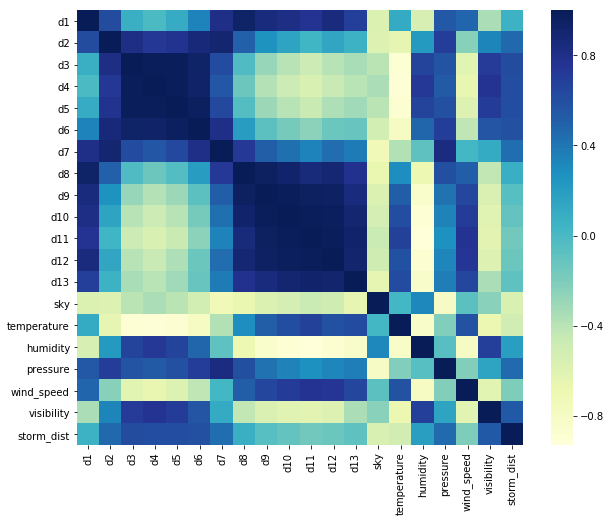

In [129]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(day_scaled.corr(), cmap = "YlGnBu")

In [130]:
day_scaled = day_scaled.transpose()

-654.3805763017858

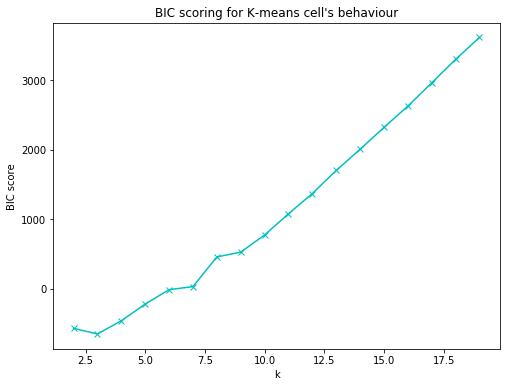

In [131]:
plot_BIC(day_scaled, range(2, day_scaled.shape[0]))[1]

The optimal number of clusters is 3

In [133]:
def cluster(X, n_clusters):
    k_means = KMeans(n_clusters=n_clusters, random_state=666)
    clusters = k_means.fit_predict(X)
    scaled_centers = k_means.cluster_centers_
    
    #PCA on df
    pca = PCA(n_components=3)
    day_pca = pca.fit_transform(X)
    print("Explained Varience: ", pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))
    
    #PCA on clusters 
    pca_centers = pd.DataFrame(pca.transform(scaled_centers), columns=['x', 'y', 'z'])
    pca_centers['cluster_id'] = pca_centers.index
    
    pca_axis = pd.DataFrame(day_pca, columns=['x', 'y', 'z'], index=X.index)
    pca_axis['cluster_id'] = clusters
   
    return pca_axis

In [164]:
def plot_pca(x, y, df, n_clusters):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=x, y=y, alpha = 0.6,hue='cluster_id', s=100, data=df, palette=sns.color_palette("Set1", n_colors=n_clusters))
    for name in df.index:
        plt.annotate(s=name, xy=(df.loc[name][x]+0.05, df.loc[name][y] + 0.05))

In [136]:
n_clusters = 3
pca_df = cluster(day_scaled, n_clusters)

Explained Varience:  [0.60442158 0.24267895 0.06471917] 0.91181969619863


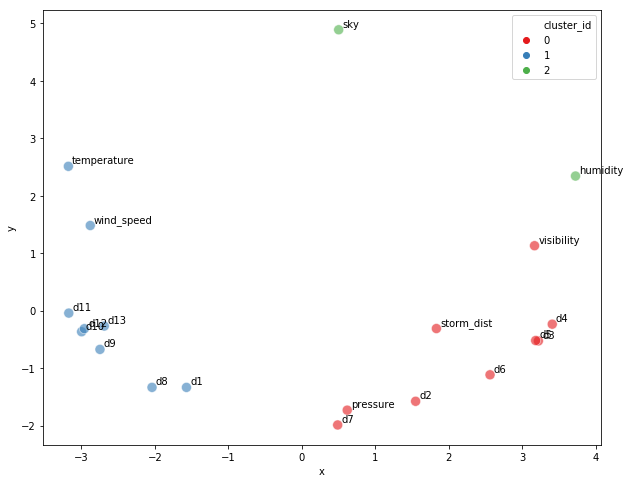

In [137]:
plot_pca('x', 'y', pca_df, n_clusters)

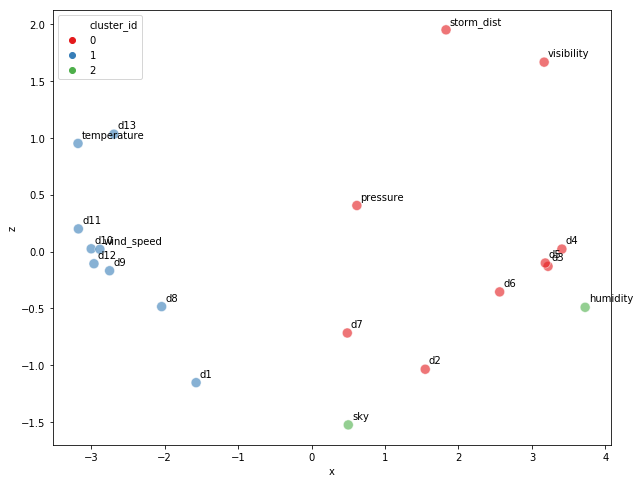

In [138]:
plot_pca('x', 'z', pca_df, n_clusters)

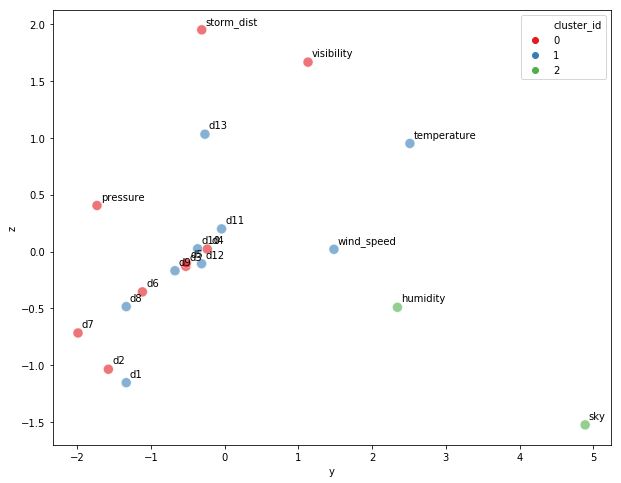

In [139]:
plot_pca('y', 'z', pca_df, n_clusters)

### Resampling by day

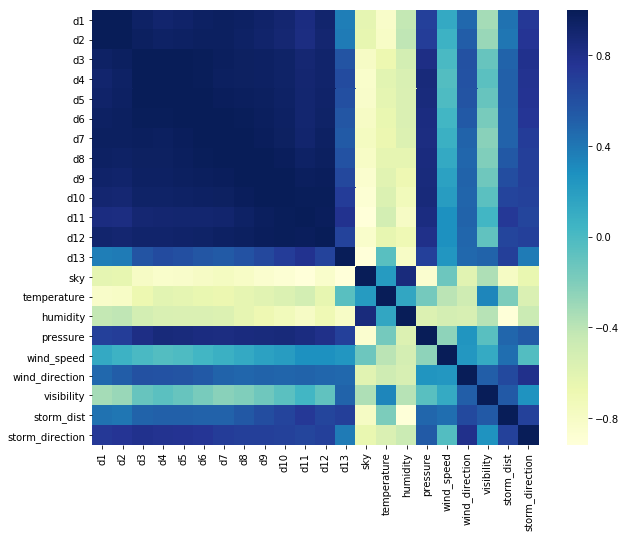

In [171]:
cols = list(data.columns)
day_scaled2 = preprocess_data(['1W'], cols, group = False)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(day_scaled2.corr(), cmap = "YlGnBu")

In [172]:
day_scaled2 = day_scaled2.transpose()

-106.28756125719849

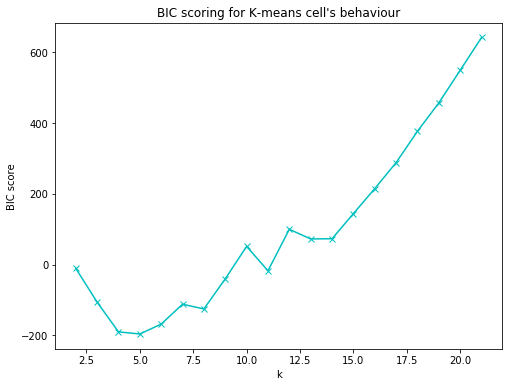

In [173]:
plot_BIC(day_scaled2, range(2, day_scaled2.shape[0]))[1]

In [175]:
n_clusters = 4
pca_df2 = cluster(day_scaled2, n_clusters)

Explained Varience:  [0.54400265 0.21061519 0.11618632] 0.870804154265718


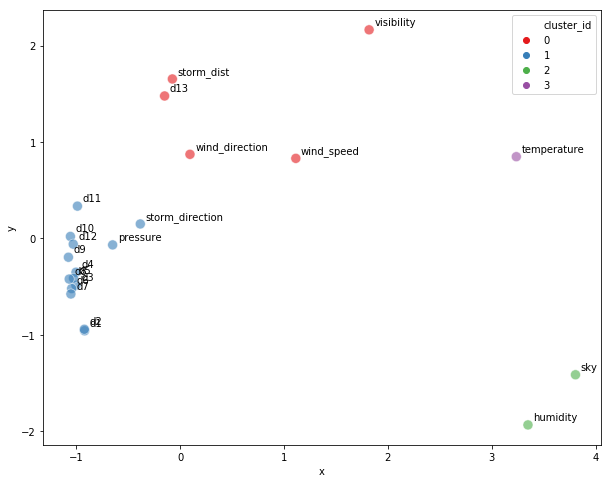

In [176]:
plot_pca('x', 'y', pca_df2, n_clusters)